In [1]:
'''
1.CIFAR-10データセットの読み込み
'''
from tensorflow.keras import datasets
(x_train, t_train), (x_test, t_test) = datasets.cifar10.load_data()

In [2]:
'''
2.畳み込みネットワークの構築
''' 
from tensorflow.keras import models, layers, optimizers, regularizers

# L2正則化の係数
weight_decay = 1e-4

# CNNを構築
model = models.Sequential()

# (第1層)畳み込み層1 正則化を行う
model.add(
    layers.Conv2D(
        filters=32,                    # フィルターの数は32
        kernel_size=(3,3),             # 3×3のフィルターを使用
        input_shape=x_train.shape[1:], # 入力データの形状
        padding='same',                # ゼロパディングを行う 
        kernel_regularizer=regularizers.l2(weight_decay),
        activation='relu'              # 活性化関数はReLU
        ))

# (第2層)プーリング層1：ウィンドウサイズは2×2
model.add(
    layers.MaxPooling2D(pool_size=(2,2)))

# (第3層)畳み込み層2　正則化を行う
model.add(
    layers.Conv2D(
        filters=128,                # フィルターの数は64
        kernel_size=(3,3),          # 3×3のフィルターを使用
        padding='same',             # ゼロパディングを行う 
        kernel_regularizer=regularizers.l2(weight_decay),
        activation='relu'           # 活性化関数はReLU
        ))

# (第4層)プーリング層2：ウィンドウサイズは2×2
model.add(
    layers.MaxPooling2D(pool_size=(2,2)))

# (第5層)畳み込み層3　正則化を行う
model.add(
    layers.Conv2D(
        filters=256,                # フィルターの数は256
        kernel_size=(3,3),          # 3×3のフィルターを使用
        padding='same',             # ゼロパディングを行う 
        kernel_regularizer=regularizers.l2(weight_decay),
        activation='relu'           # 活性化関数はReLU
        ))

# (第6層)プーリング層2：ウィンドウサイズは2×2
model.add(
    layers.MaxPooling2D(pool_size=(2,2)))

# Flatten
model.add(layers.Flatten())

# ドロップアウト：ドロップアウトは40％
model.add(layers.Dropout(0.4))
 
# （第7層）全結合層
model.add(
    layers.Dense(
        512,                   # ニューロン数は512
        activation='relu'))    # 活性化関数はReLU


# （第8層）出力層
model.add(
    layers.Dense(
        10,                    # 出力層のニューロン数は10
        activation='softmax')) # 活性化関数はソフトマックス

# 学習率
learning_rate = 0.1                  

# Sequentialオブジェクトのコンパイル
model.compile(
    # 損失関数はスパースラベル対応クロスエントロピー誤差
    loss='sparse_categorical_crossentropy',
    # オプティマイザーはSGD
    optimizer=optimizers.SGD(lr=learning_rate),
    # 学習評価として正解率を指定
    metrics=['accuracy'])

# モデルのサマリを表示
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [3]:
%%time
'''
3.学習の実行
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# ミニバッチのサイズ
batch_size = 64

# データ拡張
datagen = ImageDataGenerator(
    rescale=1.0/255.0,      # ピクセル値を255で割って正規化する
    validation_split=0.2,   # 20パーセントのデータを検証用にする
    rotation_range=15,      # 15度の範囲でランダムに回転させる
    width_shift_range=0.1,  # 横サイズの0.1の割合でランダムに水平移動
    height_shift_range=0.1, # 縦サイズの0.1の割合でランダムに垂直移動
    horizontal_flip=True,  # 水平方向にランダムに反転、左右の入れ替え
    zoom_range=0.2,         # ランダムに拡大
)

# 訓練データ用のジェネレーターを生成
training_generator = datagen.flow(x_train, t_train,
                                  batch_size=batch_size,
                                  subset='training')      # 訓練用のデータを生成
# 検証データ用のジェネレーターを生成
validation_generator = datagen.flow(x_train, t_train,
                                    batch_size=batch_size,
                                    subset='validation') # 検証用のデータを生成
# 早期終了を行うEarlyStoppingを生成
early_stopping = EarlyStopping(
    monitor='val_loss', # 監視対象は損失
    patience=20,         # 監視する回数
    verbose=1           # 早期終了をログとして出力
)

# エポック数
epochs = 200

# 学習を行う
history = model.fit(
    # 拡張データをミニバッチの数だけ生成
    training_generator,
    epochs=epochs,             # エポック数
    verbose=1,                 # 学習の進捗状況を出力する
    validation_data=validation_generator,
    # エポック終了後にearly_stoppingをコールバック
    # コールバックはリストで指定する
    callbacks=[early_stopping]
)

Train for 625 steps, validate for 157 steps
Epoch 1/200
625/625 [==============================] - 147s 235ms/step - loss: 2.0032 - accuracy: 0.2792 - val_loss: 1.6551 - val_accuracy: 0.4044
Epoch 2/200
625/625 [==============================] - 147s 235ms/step - loss: 1.6058 - accuracy: 0.4277 - val_loss: 1.4952 - val_accuracy: 0.4698
Epoch 3/200
625/625 [==============================] - 146s 233ms/step - loss: 1.4488 - accuracy: 0.4877 - val_loss: 1.3826 - val_accuracy: 0.5078
Epoch 4/200
625/625 [==============================] - 145s 232ms/step - loss: 1.3445 - accuracy: 0.5272 - val_loss: 1.2191 - val_accuracy: 0.5809
Epoch 5/200
625/625 [==============================] - 146s 233ms/step - loss: 1.2465 - accuracy: 0.5679 - val_loss: 1.1516 - val_accuracy: 0.6022
Epoch 6/200
625/625 [==============================] - 146s 233ms/step - loss: 1.1862 - accuracy: 0.5931 - val_loss: 1.0871 - val_accuracy: 0.6281
Epoch 7/200
625/625 [==============================] - 146s 234ms/step - l

625/625 [==============================] - 180s 288ms/step - loss: 0.5508 - accuracy: 0.8387 - val_loss: 0.7133 - val_accuracy: 0.7879
Epoch 56/200
625/625 [==============================] - 152s 244ms/step - loss: 0.5519 - accuracy: 0.8395 - val_loss: 0.7273 - val_accuracy: 0.7848
Epoch 57/200
625/625 [==============================] - 181s 290ms/step - loss: 0.5470 - accuracy: 0.8425 - val_loss: 0.7079 - val_accuracy: 0.7944
Epoch 58/200
625/625 [==============================] - 185s 295ms/step - loss: 0.5480 - accuracy: 0.8411 - val_loss: 0.6652 - val_accuracy: 0.8078
Epoch 59/200
625/625 [==============================] - 198s 316ms/step - loss: 0.5423 - accuracy: 0.8442 - val_loss: 0.6924 - val_accuracy: 0.7989
Epoch 60/200
625/625 [==============================] - 200s 320ms/step - loss: 0.5388 - accuracy: 0.8446 - val_loss: 0.6900 - val_accuracy: 0.8028
Epoch 61/200
625/625 [==============================] - 205s 328ms/step - loss: 0.5249 - accuracy: 0.8504 - val_loss: 0.6774 

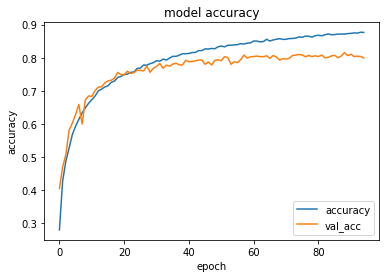

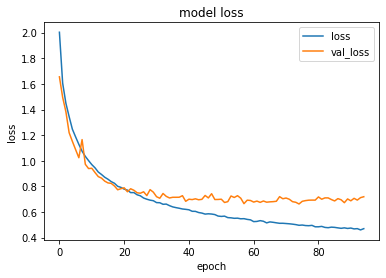

In [4]:
'''
4.損失と精度の推移をグラフにする
'''
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['accuracy'],"-",label="accuracy")
    plt.plot(history.history['val_accuracy'],"-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"-",label="loss",)
    plt.plot(history.history['val_loss'],"-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

# 損失と精度の推移をプロット
plot_history(history)

In [5]:
'''
5. テストデータによるモデルの評価
'''
# テストデータを正規化
x_test = x_test / 255

# 学習済みのモデルにテストデータを入力して損失と精度を取得
test_loss, test_acc = model.evaluate(x_test, t_test, verbose=0)
print('test_loss:', test_loss)
print('test_acc:', test_acc)

test_loss: 0.6330001251220703
test_acc: 0.833
